## !pip install torch-geometric
!pip install metric-learn
#!pip install pygraphviz
#import torch
#import torch.nn as nn
from scipy.spatial import cKDTree

#import torch.nn.functional as F
#import torch_geometric.utils as pyg_utils
#from torch_geometric.utils.convert import to_networkx
#from networkx.drawing.nx_agraph import to_agraph
#import torch.nn.parallel
#import torch_geometric
#import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#import multiprocessing
#import multiprocessing as mp
from metric_learn import MMC
from sklearn.neighbors import KDTree
#from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
#from concurrent.futures import ThreadPoolExecutor
import time
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math

In [1]:
## !pip install torch-geometric
!pip install metric-learn
#!pip install pygraphviz
#import torch
#import torch.nn as nn
from scipy.spatial import cKDTree

#import torch.nn.functional as F
#import torch_geometric.utils as pyg_utils
#from torch_geometric.utils.convert import to_networkx
#from networkx.drawing.nx_agraph import to_agraph
#import torch.nn.parallel
#import torch_geometric
#import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#import multiprocessing
#import multiprocessing as mp
from metric_learn import MMC
from sklearn.neighbors import KDTree
#from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
#from concurrent.futures import ThreadPoolExecutor
import time
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.1 MB/s eta 0:00:00


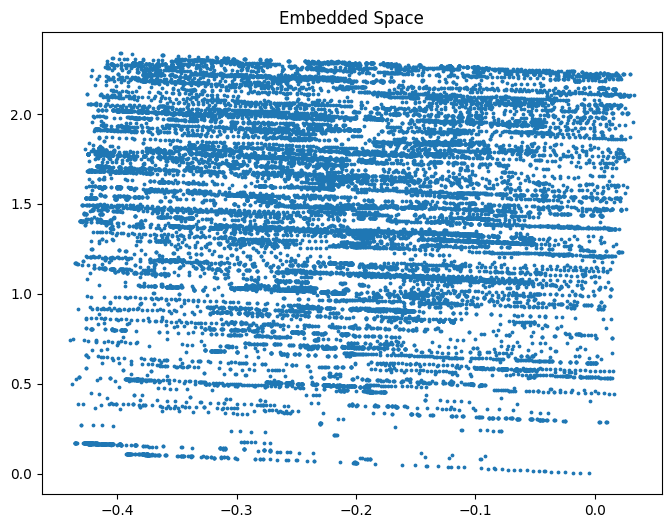

In [2]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/time-sorted-with-999/new_file_with_999_time_sorted.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)


plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:, 2], X_transformed[:, 3], s=3)
# plt.xlabel('Feature 3')
# plt.ylabel('Feature 4')
plt.title('Embedded Space')
#plt.grid(True)

# Specify the path where you want to save the image
output_path = '/kaggle/working/embedded_space.png'  # Output directory on Kaggle
plt.savefig(output_path, dpi=300)  # dpi parameter sets the resolution

plt.show()

In [3]:
# Record start time
start_time = time.time()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/time-sorted-with-999/new_file_with_999_time_sorted.csv'

# Read the first 10,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Select only the desired columns (x, y, z, t)
input_data_1 = input_data[['x', 'y', 'z', 't']]

# Extract columns for scaling
columns_to_scale = ['x', 'y', 'z', 't']
data_to_scale = input_data_1[columns_to_scale]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Load the trained MMC model from the pickle file
model_file_path = '/kaggle/input/mmc-scaled-model-pkl/mmc_model_scaled.pkl'
with open(model_file_path, 'rb') as file:
    trained_mmc_model = pickle.load(file)

# Transform the input data using the trained MMC model
X_transformed = trained_mmc_model.transform(scaled_data)

# KDTree
tree = KDTree(X_transformed, leaf_size=2)

# Query neighbors for all points
neighbors_list = []
for i in range(len(X_transformed)):
    neighbors = tree.query_radius(X_transformed[i].reshape(1, -1), r=0.03)[0]
    neighbors_list.append(neighbors)

# Extract MuonID1 column
muon_id_column = input_data['muonid']

# Count occurrences of each Muon ID
muon_id_counts = muon_id_column.value_counts()

# Create a list to store data for CSV
csv_data = []

# Initialize a variable to store the previous neighbors
previous_neighbors = set()

# Iterate over each point
for i, neighbors in enumerate(neighbors_list):
    # Check if current QPoint (i) is in the previous_neighbors set
    if i in previous_neighbors:
        continue  # Skip this QPoint if it's already in the previous_neighbors set
    
    # Remove current QPoint from neighbors list
    neighbors = [n for n in neighbors if n != i]
    
    # Convert list of neighbors to string with comma separation
    neighbors_str = ', '.join(map(str, neighbors))
    
    # Convert list of neighbor MuonIDs to string with comma separation
    neighbour_muon_ids_str = ', '.join(map(str, [muon_id_column[n] for n in neighbors]))
    
    # Calculate percentage of neighbors with the same MuonID
    total_neighbours = len(neighbors)
    same_muon_id_neighbours = neighbour_muon_ids_str.split(', ').count(str(muon_id_column[i]))
    if total_neighbours != 0:
        percentage_same_muon_id = (same_muon_id_neighbours / total_neighbours) * 100
    else:
        percentage_same_muon_id = 0  # Set percentage to 0 if total_neighbours is 0
    
    # Get hit number for the current MuonID_QP
    hit_number = muon_id_counts[muon_id_column[i]]
    
    # Calculate percentage of MuonID1 occurrences among neighbors
    if hit_number != 0:
        percentage = (same_muon_id_neighbours / hit_number) * 100
    else:
        percentage = 0
    
    # Create a dictionary for each point
    point_dict = {
        'QPoint': i,
        'MuonID_QP': muon_id_column[i],
        'Expected_hits': hit_number,
        'Neighbours': neighbors_str,  # Convert list to string
        'Neighbour_MuonIDs': neighbour_muon_ids_str,  # Convert list to string
        'Selection Purity': percentage_same_muon_id,
        'True Positive Rate': percentage  # Add Percentage column
    }
    csv_data.append(point_dict)
    
    # Update previous_neighbors with the current neighbors
    previous_neighbors.update(neighbors)
    
   # Create DataFrame from the list of dictionaries
df = pd.DataFrame(csv_data)

# print("Number of rows in the resultant CSV:", len(df))

# Save DataFrame to CSV file
df.to_csv('Before_edgerefinement.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds") 




Execution time: 4.090752363204956 seconds


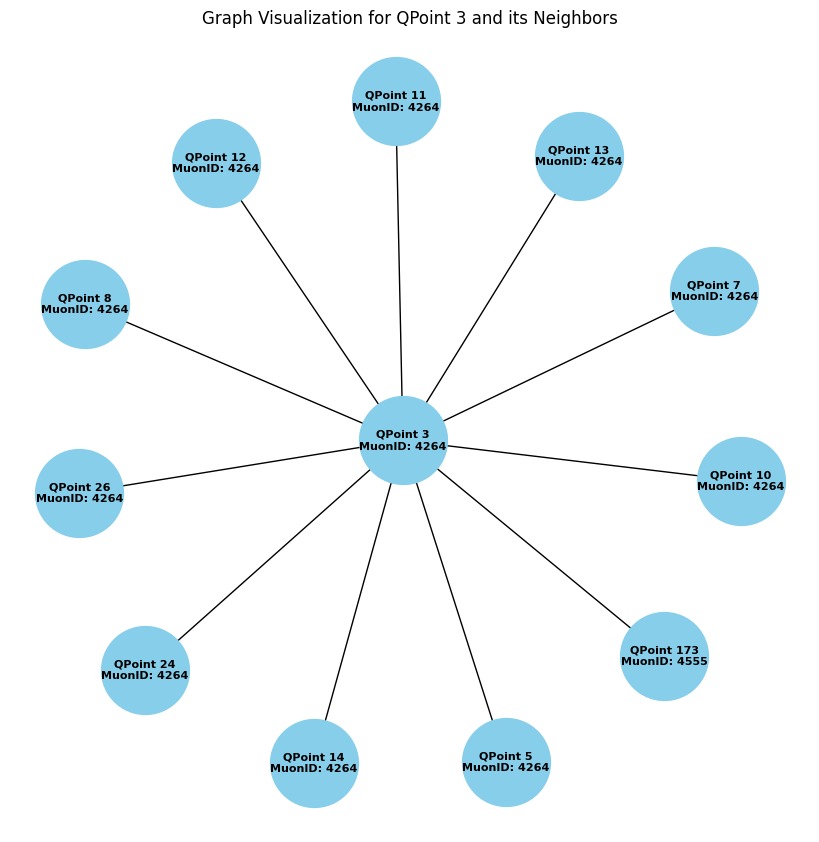

In [9]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt

# Select the first QPoint to visualize
first_qpoint = 3

# Initialize a graph object
G = nx.Graph()

# Add nodes for QPoint and its neighbors
neighbors = neighbors_list[first_qpoint]
G.add_node(first_qpoint, label=f'QPoint {first_qpoint}\nMuonID: {muon_id_column.iloc[first_qpoint]}')
for neighbor in neighbors:
    if neighbor != first_qpoint:  # Avoid adding an edge to itself
        G.add_node(neighbor, label=f'QPoint {neighbor}\nMuonID: {muon_id_column.iloc[neighbor]}')
        G.add_edge(first_qpoint, neighbor)

# Draw the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
labels = nx.get_node_attributes(G, 'label')  # Get labels from the graph

# Draw nodes with labels
nx.draw(G, pos, with_labels=False, node_size=4000, node_color='skyblue')
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black', font_family='sans-serif', font_weight='bold')

# Add title
plt.title(f'Graph Visualization for QPoint {first_qpoint} and its Neighbors')

# Save the figure
plt.savefig('/kaggle/working/graph_visualization.png')

# Display the graph
plt.show()

In [ ]:
# Load the updated DataFrame
df_grouped = pd.read_csv('/kaggle/working/Before_edge_refinement.csv')

# Plot histogram of 'True Positive Rate'
plt.figure(figsize=(8, 4))
plt.hist(df_grouped['True Positive Rate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('True Positive Rate')
plt.ylabel('Frequency')
plt.title('Histogram of True Positive Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('true_positive_rate_hist.png')
plt.show()

# Plot histogram of 'Selection Purity'
plt.figure(figsize=(8, 4))
plt.hist(df_grouped['Selection Purity'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Selection Purity')
plt.ylabel('Frequency')
plt.title('Histogram of Selection Purity')
plt.grid(True)
plt.tight_layout()
plt.savefig('selection_purity_hist.png')
plt.show()

In [10]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/working/Before_edgerefinement.csv')

# Calculate the average of the 'Percentage_Same_Muon_ID' column
percentage_same_muonid_avg = df['Selection Purity'].mean()

# Calculate the average of the 'Track_Purity' column
track_purity_avg = df['True Positive Rate'].mean()

print(f"The average of 'Percentage_Same_Muon_ID' column is: {percentage_same_muonid_avg}")
print(f"The average of 'Purity' column is: {track_purity_avg}")

The average of 'Percentage_Same_Muon_ID' column is: 26.678213061388156
The average of 'Purity' column is: 29.18983667901833


In [4]:
# Record start time
start_time = time.time()


# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/working/Before_edgerefinement.csv')

# Load the CSV file containing the z and t values
z_t_df = pd.read_csv('/kaggle/input/time-sorted-with-999/new_file_with_999_time_sorted.csv')

# Create an empty DataFrame to store the expanded data
expanded_df = pd.DataFrame(columns=['QPoint', 'Neighbour', 'MuonId_point', 'MuonId_neighbour', 'normalized_delta_z', 'normalized_delta_t'])

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    qpoint = row['QPoint']
    neighbours = row['Neighbours']
    if isinstance(neighbours, str):
        neighbours = neighbours.split(', ')
    else:
        neighbours = []
    muonid_point = row['MuonID_QP']
    muonid_neighbours = row['Neighbour_MuonIDs']
    if isinstance(muonid_neighbours, str):
        muonid_neighbours = muonid_neighbours.split(', ')
    else:
        muonid_neighbours = []
    
    # Get z and t values for QPoint and neighbours
    z_qpoint = z_t_df.iloc[qpoint]['z']
    t_qpoint = z_t_df.iloc[qpoint]['t']
    z_neighbours = z_t_df.iloc[[int(neighbour) for neighbour in neighbours]]['z']
    t_neighbours = z_t_df.iloc[[int(neighbour) for neighbour in neighbours]]['t']
    
    # Calculate absolute difference in z and t
    abs_delta_z = abs(z_qpoint - z_neighbours)
    abs_delta_t = abs(t_qpoint - t_neighbours)
    
    # Normalize delta z and delta t
    max_delta_z = z_t_df['z'].max()
    max_delta_t = z_t_df['t'].max()
    normalized_delta_z = abs_delta_z / max_delta_z
    normalized_delta_t = abs_delta_t / max_delta_t
    
    # Create a DataFrame for each row
    neighbour_df = pd.DataFrame({
        'QPoint': [qpoint] * len(neighbours),
        'Neighbour': neighbours,
        'MuonId_point': [muonid_point] * len(neighbours),
        'MuonId_neighbour': muonid_neighbours,
        'normalized_delta_z': normalized_delta_z.tolist(),
        'normalized_delta_t': normalized_delta_t.tolist()
    })
    # Append the DataFrame to the expanded DataFrame
    expanded_df = pd.concat([expanded_df, neighbour_df], ignore_index=True)

# Save the expanded DataFrame to a new CSV file
expanded_df.to_csv('for_loading_with999.csv', index=False)

# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

/tmp/ipykernel_33/2389164375.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expanded_df = pd.concat([expanded_df, neighbour_df], ignore_index=True)


Execution time: 3.9390861988067627 seconds


In [5]:
# Record start time
start_time = time.time()

# Load your CSV file into a DataFrame
df = pd.read_csv('/kaggle/working/for_loading_with999.csv')

df_2 = pd.read_csv('/kaggle/input/time-sorted-with-999/new_file_with_999_time_sorted.csv')

# Load the saved Random Forest Classifier model from the pickle file
model_file_path = '/kaggle/input/random-forest/random_forest_model.pkl'
with open(model_file_path, 'rb') as file:
    model = pickle.load(file)

# Select features
X = df[['normalized_delta_z', 'normalized_delta_t']]

# Make predictions
predictions = model.predict(X)

# Add predictions to the DataFrame
df['predictions'] = predictions

# Remove rows containing predictions of 0
df_filtered = df[df['predictions'] != 0]

# Remove the 'normalized_delta_z' and 'normalized_delta_t' columns
df_filtered = df_filtered.drop(columns=['normalized_delta_z', 'normalized_delta_t'])

# Format Neighbours, MuonId_neighbour, and predictions columns as lists
df_grouped = df_filtered.groupby('QPoint').agg({
    'Neighbour': lambda x: list(x),
    'MuonId_point': 'first',  # Take the first value of MuonId_point for each group
    'MuonId_neighbour': lambda x: list(x),
    'predictions': lambda x: list(x),
}).reset_index()

# Calculate hit number using df_2 instead of df_filtered
hit_counts = df_2['muonid'].value_counts()
df_grouped['Expected_hits'] = df_grouped['MuonId_point'].map(hit_counts)

# Define a function to calculate the percentage of same Muon ID among neighbors
def calculate_percentage(row):
    muon_id_point = row['MuonId_point']
    muon_id_neighbors = row['MuonId_neighbour']
    total_neighbors = len(muon_id_neighbors)
    same_muon_id_count = muon_id_neighbors.count(muon_id_point)
    return (same_muon_id_count / total_neighbors) * 100 if total_neighbors > 0 else 0

# Apply the function to each row and create a new column 'Percentage_Same_MuonID'
df_grouped['Selection Purity'] = df_grouped.apply(calculate_percentage, axis=1)

# Define a function to calculate track purity
def calculate_track_purity(row):
    same_muon_id_count = row['MuonId_neighbour'].count(row['MuonId_point'])
    return (same_muon_id_count / row['Expected_hits']) * 100 if row['Expected_hits'] > 0 else 0

# Apply the function to each row and create a new column 'Purity'
df_grouped['True Positive Rate'] = df_grouped.apply(calculate_track_purity, axis=1)

# Save the updated DataFrame to a new CSV file
df_grouped.to_csv('After_refinement.csv', index=False)
# Calculate execution time
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")



Execution time: 1.3217196464538574 seconds


In [7]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/working/After_refinement.csv')

# Calculate the average of the 'Percentage_Same_Muon_ID' column
percentage_same_muonid_avg = df['Selection Purity'].mean()

# Calculate the average of the 'Track_Purity' column
track_purity_avg = df['True Positive Rate'].mean()

print(f"The average of 'Percentage_Same_Muon_ID' column is: {percentage_same_muonid_avg}")
print(f"The average of 'Purity' column is: {track_purity_avg}")

The average of 'Percentage_Same_Muon_ID' column is: 71.02901770786121
The average of 'Purity' column is: 23.64133435600903


In [ ]:

# Load the updated DataFrame
df_grouped = pd.read_csv('/kaggle/working/After_refinement.csv')

# Plot histogram of 'True Positive Rate'
plt.figure(figsize=(8, 4))
plt.hist(df_grouped['True Positive Rate'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('True Positive Rate')
plt.ylabel('Frequency')
plt.title('Histogram of True Positive Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('true_positive_rate_hist.png')
plt.show()

# Plot histogram of 'Selection Purity'
plt.figure(figsize=(8, 4))
plt.hist(df_grouped['Selection Purity'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Selection Purity')
plt.ylabel('Frequency')
plt.title('Histogram of Selection Purity')
plt.grid(True)
plt.tight_layout()
plt.savefig('selection_purity_hist.png')
plt.show()

In [2]:
# Define the file path of the CSV file containing the Qpoints
qpoints_file_path = '/kaggle/input/after-refinement-111/After_refinement.csv'

# Read the first column (Qpoints) from the CSV file into a list
qpoints_list = pd.read_csv(qpoints_file_path).iloc[:, 0].tolist()

# Define the file path of the CSV file containing the input data
input_file_path = '/kaggle/input/time-sorted-with-999/new_file_with_999_time_sorted.csv'

# Read the first 30,000 rows from the CSV file into a pandas DataFrame
input_data = pd.read_csv(input_file_path, nrows=30000)

# Function to calculate phi
def calc_phi(y, x):
    phi = math.atan2(y, x)
    if phi < 0:
        phi += 2 * math.pi
    return phi

# Function to get original x, y, z, t, and muonid values for given QPoints
def get_original_values(qpoints, input_data):
    result = input_data.loc[qpoints, ['muonid', 'x', 'y', 'z', 't']]
    result.insert(0, 'Qpoints', qpoints)  # Insert Qpoints column at the beginning
    return result

# Apply calc_phi function to create a new 'phi' column
original_values_with_qpoints = get_original_values(qpoints_list, input_data)
original_values_with_qpoints['phi'] = original_values_with_qpoints.apply(lambda row: calc_phi(row['y'], row['x']), axis=1)

# Save the resulting DataFrame to a CSV file in the Kaggle working directory
output_file_path = '/kaggle/working/Qpoints_original_values_with_phi.csv'
original_values_with_qpoints.to_csv(output_file_path, index=False)

print(f"Original values with Qpoints, muonid, x, y, z, t, and phi saved to {output_file_path}")

Original values with Qpoints, muonid, x, y, z, t, and phi saved to /kaggle/working/Qpoints_original_values_with_phi.csv
